In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import random
from tensorflow.keras import models, layers  # Import models and layers
from scipy.ndimage import rotate
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

In [ ]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension for CNN
x_train = x_train[..., np.newaxis]  # Shape (60000, 28, 28, 1)
x_test = x_test[..., np.newaxis]    # Shape (10000, 28, 28, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define the CNN model
def cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Function to perform cross-validation
def cross_validate_cnn(x, y, n_splits=5, epochs=5, batch_size=64):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_index, val_index in kf.split(x):
        x_fold_train, x_fold_val = x[train_index], x[val_index]
        y_fold_train, y_fold_val = y[train_index], y[val_index]

        # Build and train the model
        model = cnn_model(input_shape=(28, 28, 1))
        model.fit(x_fold_train, y_fold_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Evaluate on validation set
        val_loss, val_accuracy = model.evaluate(x_fold_val, y_fold_val, verbose=0)
        fold_accuracies.append(val_accuracy)

    return np.mean(fold_accuracies), np.std(fold_accuracies)

In [ ]:
# Learning Curve: Accuracy vs Training Set Size
def plot_learning_curve(x, y, fractions, n_splits=5, epochs=5, batch_size=64):
    mean_accuracies = []
    std_accuracies = []

    for fraction in fractions:
        # Subset the data
        num_samples = int(len(x) * fraction)
        indices = random.sample(range(len(x)), num_samples)
        x_subset, y_subset = x[indices], y[indices]

        # Perform cross-validation on the subset
        mean_acc, std_acc = cross_validate_cnn(x_subset, y_subset, n_splits=n_splits, epochs=epochs, batch_size=batch_size)
        mean_accuracies.append(mean_acc)
        std_accuracies.append(std_acc)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.errorbar(fractions, mean_accuracies, yerr=std_accuracies, fmt='-o', capsize=5)
    plt.title('Learning Curve: Accuracy vs Training Set Size')
    plt.xlabel('Fraction of Training Set Used')
    plt.ylabel('Cross-Validated Accuracy')
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cross-validated Accuracy: 0.9867 ± 0.0024
Test Set Accuracy: 0.9909
Test Set Error Rate: 0.0091


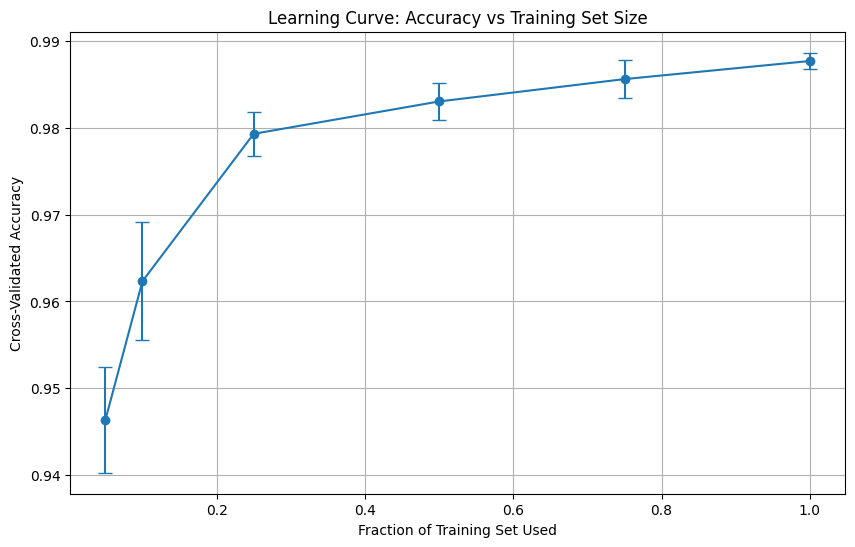

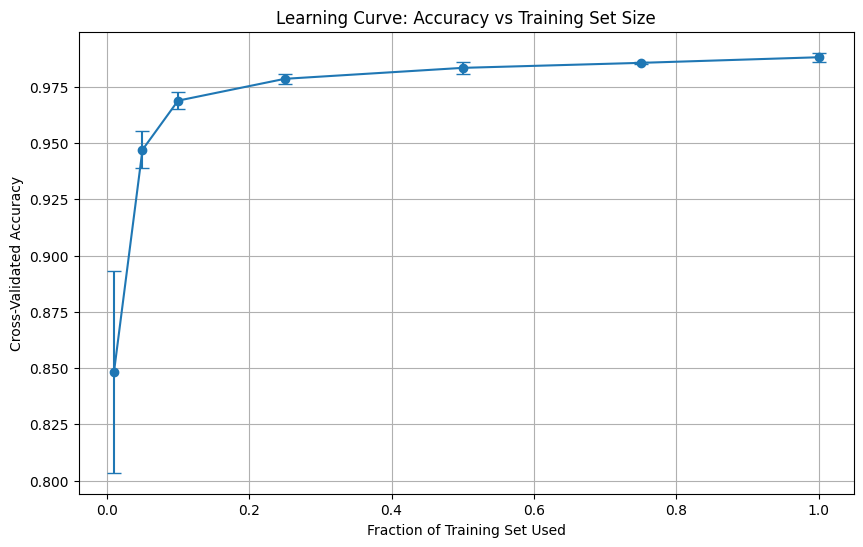

In [ ]:
random.seed(2424)

#Perform cross-validation on the Original
mean_acc, std_acc = cross_validate_cnn(x_train, y_train, n_splits=5, epochs=5, batch_size=64)

# Evaluate on the test set
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=0)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

# Print results
print(f"Cross-validated Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set Error Rate: {1 - test_accuracy:.4f}")

# Plot the learning curve
fractions = [1.0, 0.75, 0.5, 0.25, 0.1, 0.05]
fractions_1 = [1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]
plot_learning_curve(x_train, y_train, fractions, n_splits=5, epochs=5, batch_size=64)

plot_learning_curve(x_train, y_train, fractions_1, n_splits=5, epochs=5, batch_size=64)


In [ ]:
# Function to get the most and least typical images based on PCA
def get_typical_and_outlier_images_pca(images, num_images=5, variance_threshold=0.9):
    """
    Identifies the most typical and outlier images for a given set of images based on PCA.

    Parameters:
    - images (np.ndarray): Array of images with shape (n_samples, 28, 28, 1).
    - num_images (int): Number of typical and outlier images to return.
    - variance_threshold (float): Proportion of variance to retain in PCA.

    Returns:
    - typical_images (np.ndarray): Most typical images.
    - outlier_images (np.ndarray): Most outlier images.
    """
    # Flatten images for PCA (28x28 -> 784 features)
    flattened_images = images.reshape(images.shape[0], -1)  # Shape: (n_samples, 784)

    # Apply PCA
    pca = PCA()
    pca.fit(flattened_images)

    # Find number of components to explain desired variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= variance_threshold)[0][0] + 1

    # Project images to reduced PCA space
    reduced_images = pca.transform(flattened_images)[:, :n_components]

    # Calculate distance of each image from the mean in PCA space
    mean_reduced_image = np.mean(reduced_images, axis=0)
    distances = np.linalg.norm(reduced_images - mean_reduced_image, axis=1)

    # Find most typical and outlier indices
    most_typical_indices = np.argsort(distances)[:num_images]  # Closest to mean
    most_different_indices = np.argsort(distances)[-num_images:]  # Farthest from mean

    return images[most_typical_indices], images[most_different_indices]

In [ ]:

# Visualize the most typical and outlier images
def visualize_typical_outlier_images_subset(x_data, y_data, digit, num_images=5):
    """
    Visualize the most typical and outlier images for a specific digit in the reduced subset.

    Parameters:
    - x_data (np.ndarray): Images in the reduced subset.
    - y_data (np.ndarray): Labels corresponding to the images.
    - digit (int): The digit to analyze (0-9).
    - num_images (int): Number of typical and outlier images to visualize.
    """
    # Filter the subset for the given digit
    digit_indices = np.argmax(y_data, axis=1) == digit
    digit_images = x_data[digit_indices]

    # Get typical and outlier images
    typical_images, outlier_images = get_typical_and_outlier_images_pca(digit_images, num_images)

    # Plot typical and outlier images
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Most Typical and Outlier Images for Digit {digit} (5% Subset)")

    # Plot typical images
    for i, image in enumerate(typical_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title("Typical")
        plt.axis('off')

    # Plot outlier images
    for i, image in enumerate(outlier_images):
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title("Outlier")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
random.seed(2424)
# Randomly select 5% of the MNIST training data
fraction = 0.05
num_samples = int(len(x_train) * fraction)
indices = random.sample(range(len(x_train)), num_samples)
x_subset, y_subset = x_train[indices], y_train[indices]

# Define the rotation angles
rotation_angles_list1 = [angle for angle in range(-45, 50, 5) if angle != 0]  # -45 to 45 degrees in steps of 5
rotation_angles_list2 = [angle for angle in range(-90, 95, 5) if angle != 0]  # -90 to 90 degrees in steps of 5
rotation_angles_list3 = [angle for angle in range(-180, 185, 5) if angle != 0]  # -180 to 90 degrees in steps of 5

padding_size = 8  # Padding to prevent digit cutoff


Analyzing digit 0:


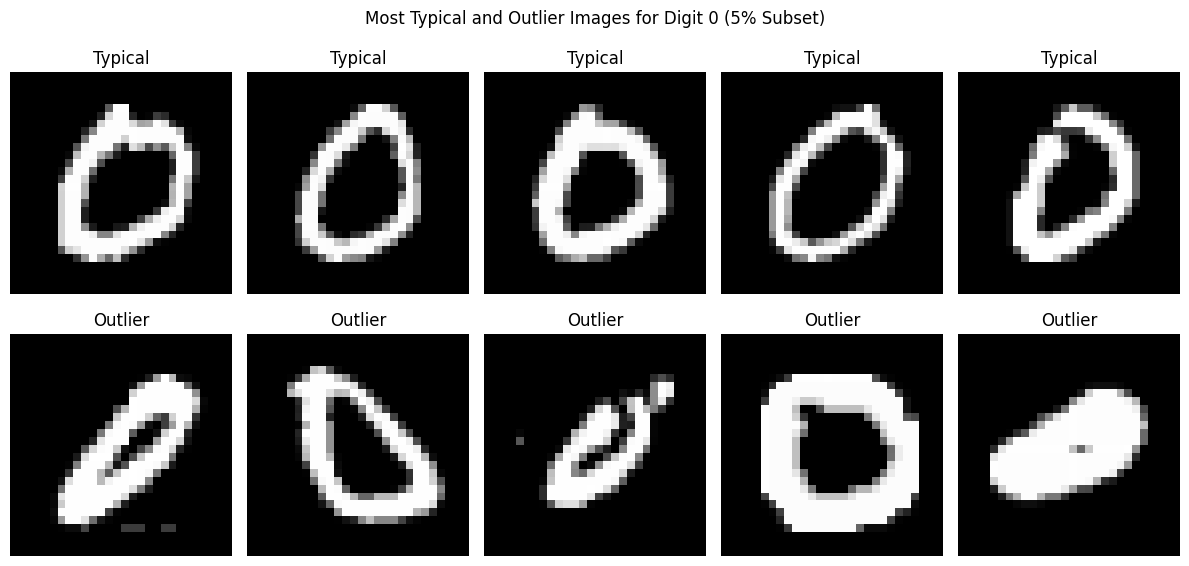


Analyzing digit 1:


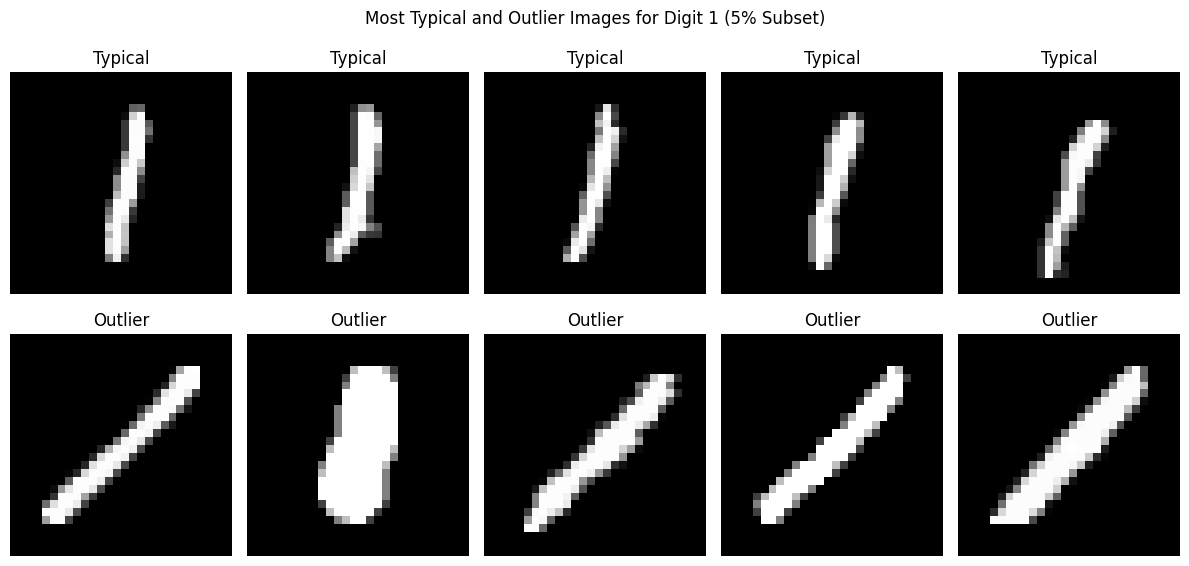


Analyzing digit 2:


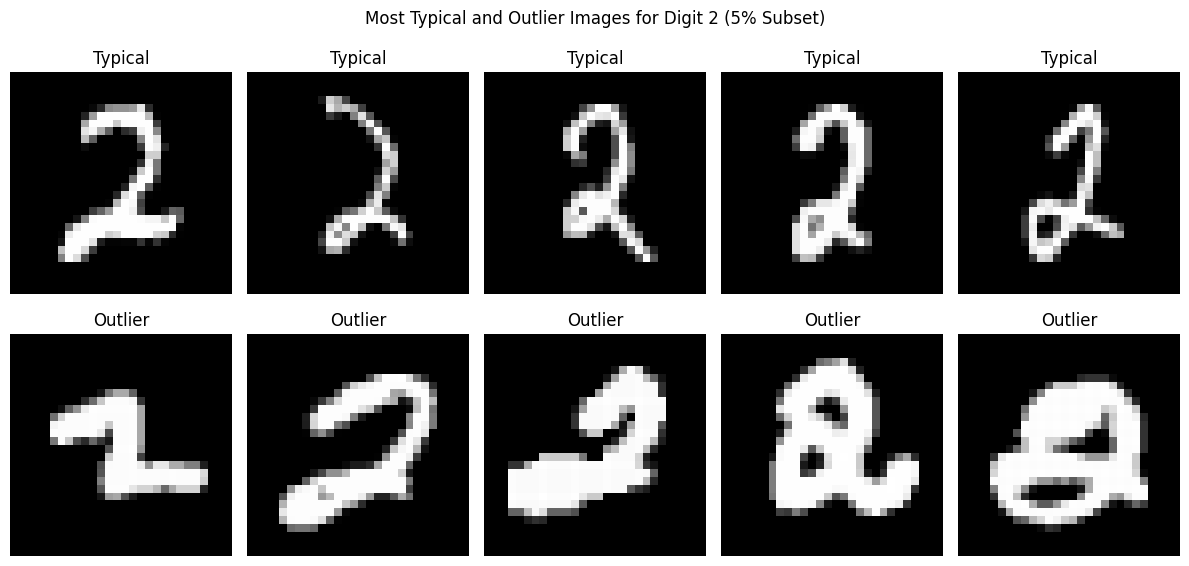


Analyzing digit 3:


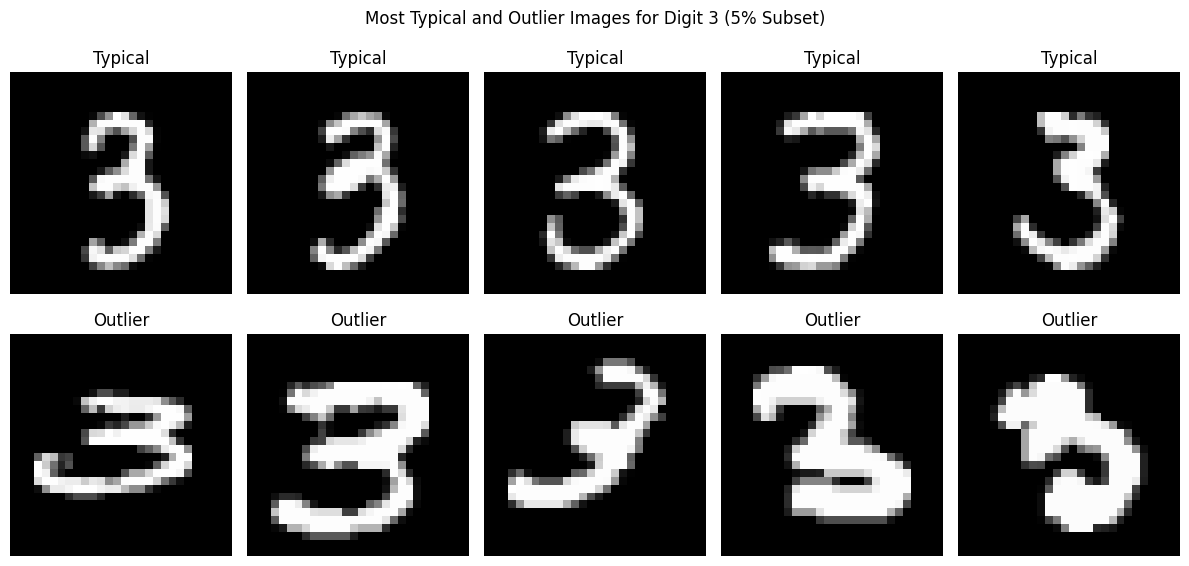


Analyzing digit 4:


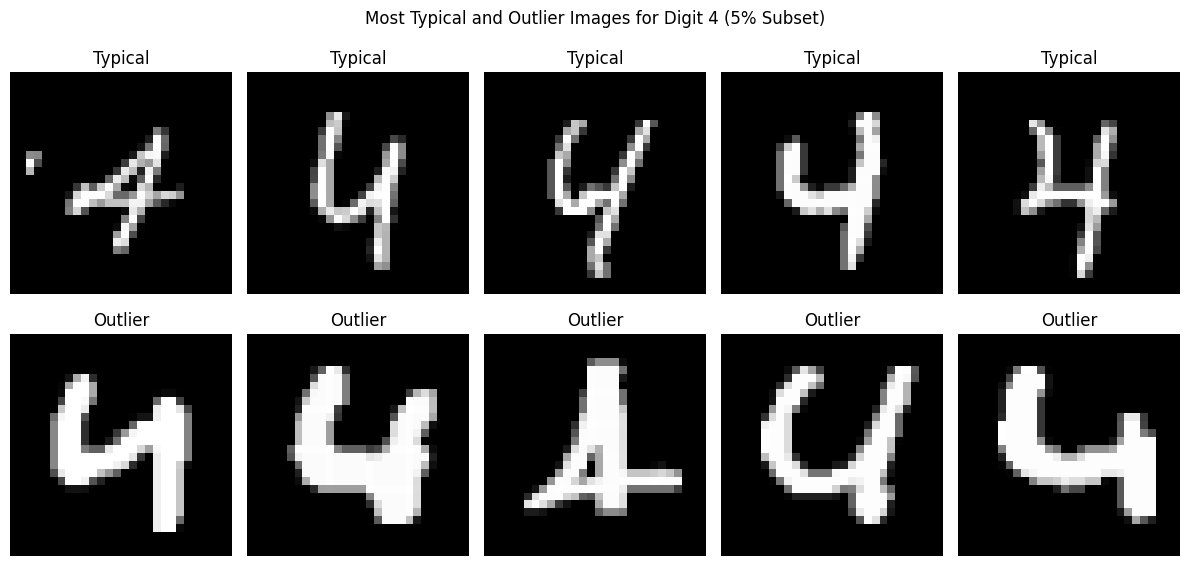


Analyzing digit 5:


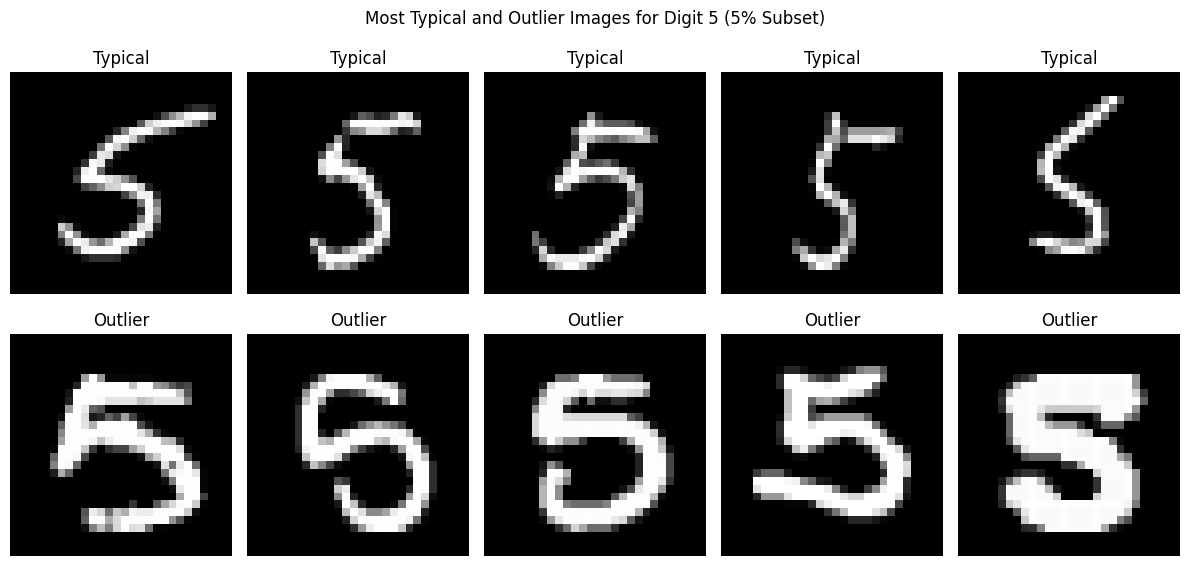


Analyzing digit 6:


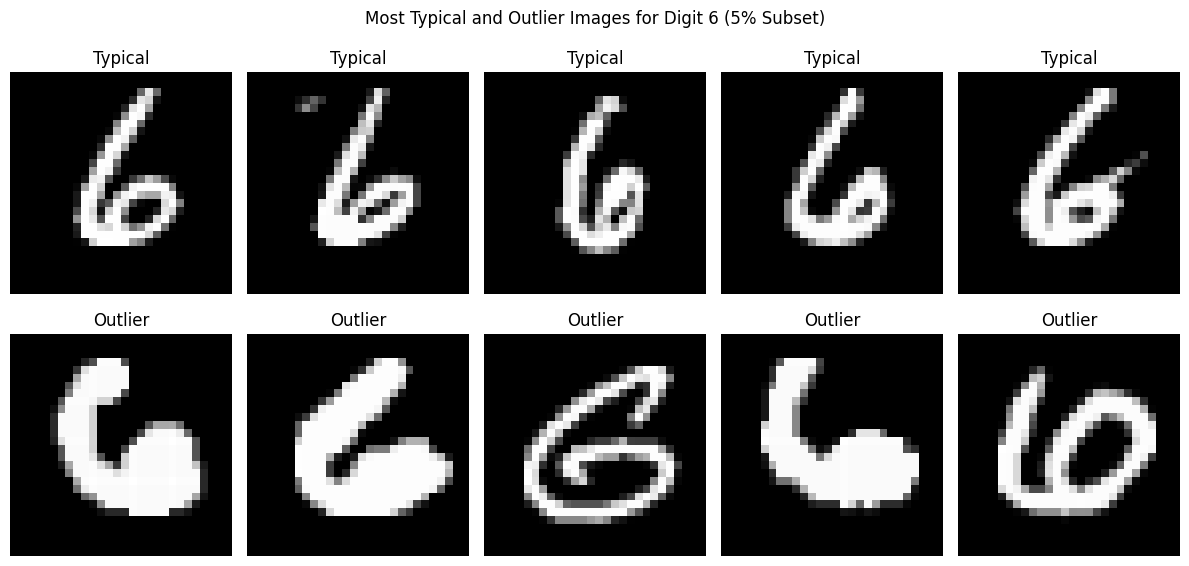


Analyzing digit 7:


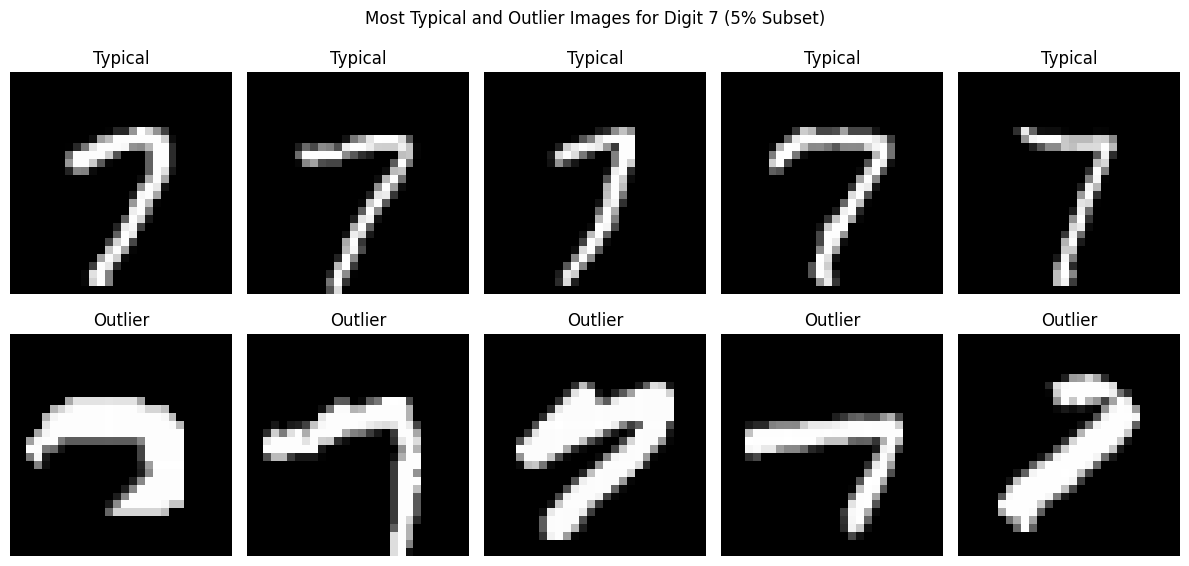


Analyzing digit 8:


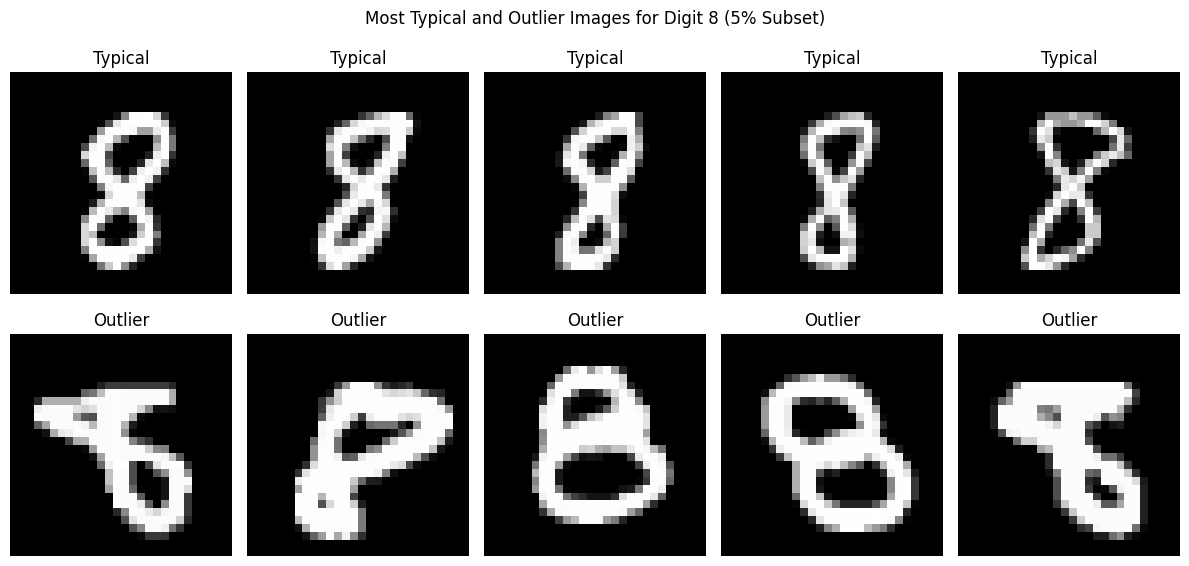


Analyzing digit 9:


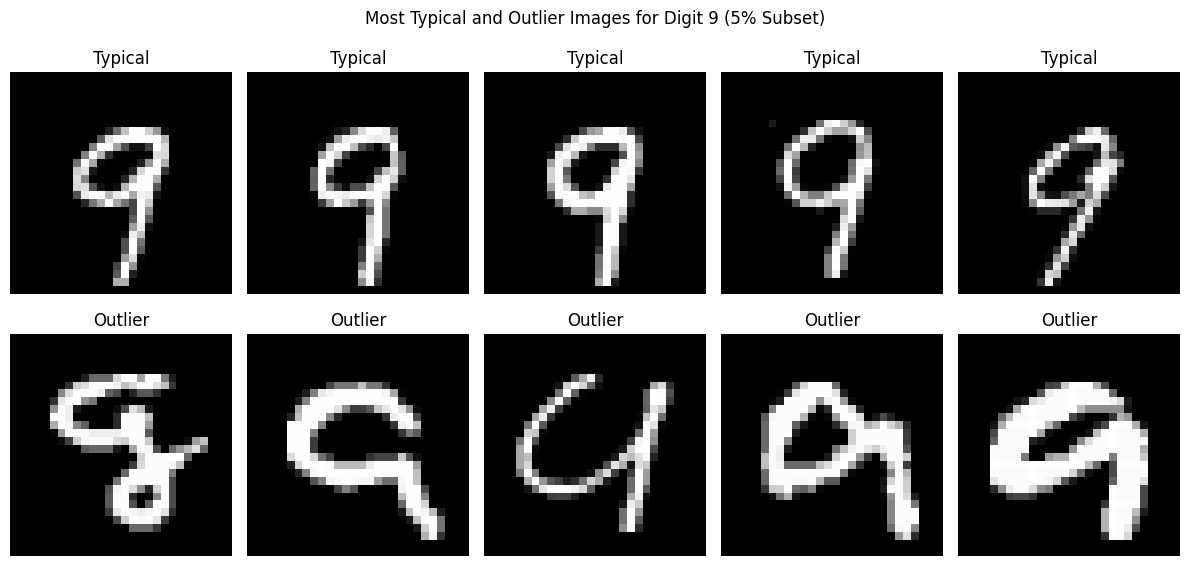

In [ ]:
# Visualize typical and outlier images for each digit (0–9)
for digit in range(10):
    print(f"\nAnalyzing digit {digit}:")
    visualize_typical_outlier_images_subset(x_subset, y_subset, digit=digit, num_images=5)

In [ ]:
# Function to pad, rotate, and resize images
def pad_rotate_resize_images(images, angles, target_size=(28, 28)):
    """
    Pads, rotates, and resizes the given images.

    Parameters:
    - images (np.ndarray): Array of images to be processed (n_samples, 28, 28, 1).
    - angles (list of int): List of angles to rotate the images.
    - target_size (tuple of int): Final size of the images after resizing (height, width).

    Returns:
    - augmented_images (np.ndarray): Rotated and resized images.
    """
    augmented_images = []

    for image in images:
        # Pad the image
        padded_image = np.pad(image, ((padding_size, padding_size), (padding_size, padding_size), (0, 0)), mode='constant', constant_values=0)

        # Rotate and resize the padded image for each angle
        for angle in angles:
            rotated_image = rotate(padded_image, angle, reshape=False, mode='constant', cval=0)
            resized_image = resize(rotated_image, target_size, mode='constant', anti_aliasing=True)
            augmented_images.append(resized_image)

    return np.array(augmented_images)

In [ ]:
# Process the data for rotation_angles_list1
x_augmented_list1 = pad_rotate_resize_images(x_subset, rotation_angles_list1)
y_augmented_list1 = np.repeat(y_subset, len(rotation_angles_list1), axis=0)

# Process the data for rotation_angles_list2
x_augmented_list2 = pad_rotate_resize_images(x_subset, rotation_angles_list2)
y_augmented_list2 = np.repeat(y_subset, len(rotation_angles_list2), axis=0)

# Process the data for rotation_angles_list3
x_augmented_list3 = pad_rotate_resize_images(x_subset, rotation_angles_list3)
y_augmented_list3 = np.repeat(y_subset, len(rotation_angles_list3), axis=0)

# Combine data for each case
x_combined_list1 = np.concatenate((x_subset, x_augmented_list1), axis=0)
y_combined_list1 = np.concatenate((y_subset, y_augmented_list1), axis=0)

x_combined_list2 = np.concatenate((x_subset, x_augmented_list2), axis=0)
y_combined_list2 = np.concatenate((y_subset, y_augmented_list2), axis=0)

x_combined_list3 = np.concatenate((x_subset, x_augmented_list3), axis=0)
y_combined_list3 = np.concatenate((y_subset, y_augmented_list3), axis=0)

# Print results
print(f"Original 5% subset size: {x_subset.shape[0]}")
print(f"Augmented subset size (including original, from -45 to 45 degrees): {x_combined_list1.shape[0]}")
print(f"Augmented subset size (including original, from -90 to 90 degrees): {x_combined_list2.shape[0]}")
print(f"Augmented subset size (including original, from -180 to 180 degrees): {x_combined_list3.shape[0]}")

Original 5% subset size: 3000
Augmented subset size (including original, from -45 to 45 degrees): 57000
Augmented subset size (including original, from -90 to 90 degrees): 111000
Augmented subset size (including original, from -180 to 180 degrees): 219000


In [ ]:
# Cross-validation on the original 5% subset
mean_acc_original, std_acc_original = cross_validate_cnn(x_subset, y_subset, n_splits=5, epochs=5, batch_size=64)

# Cross-validation on the augmented dataset (including original, from -45 to 45 degrees)
mean_acc_augmented1, std_acc_augmented1 = cross_validate_cnn(x_augmented_list1, y_augmented_list1, n_splits=5, epochs=5, batch_size=64)

# Cross-validation on the augmented dataset (including original, from -90 to 90 degrees)
mean_acc_augmented2, std_acc_augmented2 = cross_validate_cnn(x_augmented_list2, y_augmented_list2, n_splits=5, epochs=5, batch_size=64)

# Cross-validation on the augmented dataset (including original, from -180 to 180 degrees)
mean_acc_augmented3, std_acc_augmented3 = cross_validate_cnn(x_augmented_list3, y_augmented_list3, n_splits=5, epochs=5, batch_size=64)

# Print results for comparison
print(f"Cross-validated Accuracy on Original 5% Subset: {mean_acc_original:.4f} ± {std_acc_original:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -45 to 45 degrees): {mean_acc_augmented1:.4f} ± {std_acc_augmented1:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -90 to 90 degrees): {mean_acc_augmented2:.4f} ± {std_acc_augmented2:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -180 to 180 degrees): {mean_acc_augmented3:.4f} ± {std_acc_augmented3:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cross-validated Accuracy on Original 5% Subset: 0.9510 ± 0.0056
Cross-validated Accuracy on Augmented Data (including original, from -45 to 45 degrees): 0.9879 ± 0.0022
Cross-validated Accuracy on Augmented Data (including original, from -90 to 90 degrees): 0.9902 ± 0.0018
Cross-validated Accuracy on Augmented Data (including original, from -180 to 180 degrees): 0.9885 ± 0.0018


In [ ]:
random.seed(2424)
# Randomly select 1% of the MNIST training data
fraction = 0.01
num_samples = int(len(x_train) * fraction)
indices = random.sample(range(len(x_train)), num_samples)
x_subset_percent1, y_subset_percent1 = x_train[indices], y_train[indices]

In [ ]:
# Process the data for rotation_angles_list1
x_augmented_list1_1 = pad_rotate_resize_images(x_subset_percent1, rotation_angles_list1)
y_augmented_list1_1 = np.repeat(y_subset_percent1, len(rotation_angles_list1), axis=0)

# Process the data for rotation_angles_list2
x_augmented_list2_1 = pad_rotate_resize_images(x_subset_percent1, rotation_angles_list2)
y_augmented_list2_1 = np.repeat(y_subset_percent1, len(rotation_angles_list2), axis=0)

# Process the data for rotation_angles_list3
x_augmented_list3_1 = pad_rotate_resize_images(x_subset_percent1, rotation_angles_list3)
y_augmented_list3_1 = np.repeat(y_subset_percent1, len(rotation_angles_list3), axis=0)

# Combine data for each case
x_combined_list1_1 = np.concatenate((x_subset_percent1, x_augmented_list1), axis=0)
y_combined_list1_2 = np.concatenate((y_subset_percent1, y_augmented_list1), axis=0)

x_combined_list2_1 = np.concatenate((x_subset_percent1, x_augmented_list2), axis=0)
y_combined_list2_1 = np.concatenate((y_subset_percent1, y_augmented_list2), axis=0)

x_combined_list3_1 = np.concatenate((x_subset_percent1, x_augmented_list3), axis=0)
y_combined_list3_1 = np.concatenate((y_subset_percent1, y_augmented_list3), axis=0)

# Print results
print(f"Original 1% subset size: {x_subset_percent1.shape[0]}")
print(f"Augmented subset size (including original, from -45 to 45 degrees): {x_combined_list1_1.shape[0]}")
print(f"Augmented subset size (including original, from -90 to 90 degrees): {x_combined_list2_1.shape[0]}")
print(f"Augmented subset size (including original, from -180 to 180 degrees): {x_combined_list3_1.shape[0]}")

Original 1% subset size: 600
Augmented subset size (including original, from -45 to 45 degrees): 54600
Augmented subset size (including original, from -90 to 90 degrees): 108600
Augmented subset size (including original, from -180 to 180 degrees): 216600


In [ ]:
# Cross-validation on the original 1% subset
mean_acc_original, std_acc_original = cross_validate_cnn(x_subset_percent1, y_subset_percent1, n_splits=5, epochs=5, batch_size=64)

# Cross-validation on the augmented dataset (including original, from -45 to 45 degrees)
mean_acc_augmented1, std_acc_augmented1 = cross_validate_cnn(x_augmented_list1_1, y_augmented_list1_1, n_splits=5, epochs=5, batch_size=64)

# Cross-validation on the augmented dataset (including original, from -90 to 90 degrees)
mean_acc_augmented2, std_acc_augmented2 = cross_validate_cnn(x_augmented_list2_1, y_augmented_list2_1, n_splits=5, epochs=5, batch_size=64)

# Cross-validation on the augmented dataset (including original, from -180 to 180 degrees)
mean_acc_augmented3, std_acc_augmented3 = cross_validate_cnn(x_augmented_list3_1, y_augmented_list3_1, n_splits=5, epochs=5, batch_size=64)

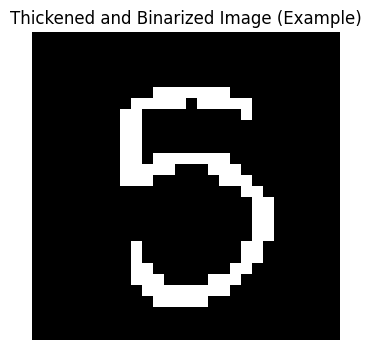

Original augmented dataset size: 21000
Final dataset size after adding thickness levels: 21250


In [ ]:

# Function to thicken, binarize, and generate multiple thickness levels for images
def augment_with_thickness_levels(images, indices, thickness_levels, target_size=(28, 28), padding_size=8, threshold=0.5):
    """
    Apply Gaussian filters with multiple thickness levels to images, binarize, and crop back to the target size.

    Parameters:
    - images (np.ndarray): Array of images to be processed (n_samples, 28, 28, 1).
    - indices (list of int): Indices of images to apply thickening.
    - thickness_levels (list of float): List of Gaussian kernel standard deviations for thickness levels.
    - target_size (tuple of int): Final size of the images after cropping (height, width).
    - padding_size (int): Padding size used before cropping.
    - threshold (float): Threshold for binarization (0 to 1).

    Returns:
    - thickened_images (np.ndarray): Array of thickened and binarized images.
    - thickened_labels (np.ndarray): Labels corresponding to the thickened images.
    """
    thickened_images = []
    thickened_labels = []

    for idx in indices:
        # Pad the image
        padded_image = np.pad(images[idx], ((padding_size, padding_size), (padding_size, padding_size), (0, 0)), mode='constant', constant_values=0)

        for sigma in thickness_levels:
            # Apply Gaussian filter for thickness
            thickened_image = gaussian_filter(padded_image, sigma=sigma)

            # Convert to binary (binarize after thickening)
            binary_image = (thickened_image > threshold).astype(np.float32)

            # Crop back to the original size
            start = padding_size
            end = start + target_size[0]
            cropped_image = binary_image[start:end, start:end]

            # Append the augmented image and its label
            thickened_images.append(cropped_image)
            thickened_labels.append(y_subset[idx])  # Use the same label as the original image

    return np.array(thickened_images), np.array(thickened_labels)

# Define thickness levels
thickness_levels = [0.5, 0.7, 1.0, 1.2, 1.5]  # Gaussian kernel standard deviations

# Apply thickening and binarization to the 50 most typical images
typical_indices = np.random.choice(len(x_subset), 50, replace=False)

# Apply thickness augmentation to the 50 most typical images
x_thickened_augmented, y_thickened_augmented = augment_with_thickness_levels(x_subset, typical_indices, thickness_levels)

# Combine original and thickened augmented data
x_combined = np.concatenate((x_augmented_combined, x_thickened_augmented), axis=0)
y_combined = np.concatenate((y_augmented_combined, y_thickened_augmented), axis=0)

# Visualize one of the thickened and binarized images for a specific thickness level
plt.figure(figsize=(4, 4))
plt.imshow(x_thickened_augmented[0].squeeze(), cmap='gray')
plt.title("Thickened and Binarized Image (Example)")
plt.axis('off')
plt.show()

print(f"Original augmented dataset size: {x_augmented_combined.shape[0]}")
print(f"Final dataset size after adding thickness levels: {x_combined.shape[0]}")


In [ ]:
# Function to apply thickness augmentation
def apply_thickness(images, thickness_levels):
    """
    Applies Gaussian filtering to add thickness to the images.

    Parameters:
    - images (np.ndarray): Array of images to augment (n_samples, 28, 28, 1).
    - thickness_levels (list of float): Gaussian kernel standard deviations for thickness.

    Returns:
    - thickened_images (np.ndarray): All images with thickness applied (n_samples, 28, 28, 1).
    """
    thickened_images = []
    for image in images:
        # Pad the image
        padded_image = np.pad(image, ((padding_size, padding_size), (padding_size, padding_size), (0, 0)),
                              mode='constant', constant_values=0)
        for thickness in thickness_levels:
            # Apply Gaussian filter
            thickened_image = gaussian_filter(padded_image, sigma=thickness)
            binary_image = (thickened_image > 50).astype(np.uint8) * 255  # Binarize
            # Crop back to 28x28 and add channel dimension
            cropped_image = binary_image[padding_size:padding_size+28, padding_size:padding_size+28]
            thickened_images.append(cropped_image[..., np.newaxis])  # Ensure shape (28, 28, 1)
    return np.array(thickened_images)

# Apply thickness augmentation to rotated images
x_thickened = apply_thickness(x_augmented, thickness_levels)

# Ensure the thickened images have the correct shape
x_thickened = x_thickened.squeeze(-1)  # Remove the extra last dimension

# Debugging shapes before concatenation
print(f"x_subset shape: {x_subset.shape}")
print(f"x_augmented shape: {x_augmented.shape}")
print(f"x_thickened shape after fixing: {x_thickened.shape}")

# Combine original, rotated, and thickened datasets
x_combined_final = np.concatenate((x_subset, x_augmented, x_thickened), axis=0)
y_combined_final = np.concatenate((y_subset, y_augmented, np.repeat(y_augmented, len(thickness_levels), axis=0)), axis=0)

# Final dataset shapes
print(f"Final combined dataset size: {x_combined_final.shape[0]}")
print(f"Final combined dataset shape: {x_combined_final.shape}")
print(f"Final combined labels shape: {y_combined_final.shape}")



x_subset shape: (3000, 28, 28, 1)
x_augmented shape: (18000, 28, 28, 1)
x_thickened shape after fixing: (90000, 28, 28, 1)
Final combined dataset size: 111000
Final combined dataset shape: (111000, 28, 28, 1)
Final combined labels shape: (111000, 10)


In [ ]:
# Function to run CNN with cross-validation and compare datasets
def compare_datasets_with_cnn(x_original, y_original, x_augmented, y_augmented, x_combined, y_combined, n_splits=5, epochs=5, batch_size=64):
    """
    Compares CNN performance using cross-validation on three datasets:
    1. Original 5% data
    2. Original 5% + rotations
    3. Original 5% + rotations + thickness augmentation

    Parameters:
    - x_original, y_original: Original 5% dataset.
    - x_augmented, y_augmented: Dataset with original + rotations.
    - x_combined, y_combined: Dataset with original + rotations + thickness.
    - n_splits: Number of splits for cross-validation.
    - epochs: Number of training epochs.
    - batch_size: Training batch size.

    Returns:
    - A dictionary of mean accuracies and standard deviations for each dataset.
    """
    results = {}

    datasets = {
        "Original 5%": (x_original, y_original),
        "Original + Rotations": (x_augmented, y_augmented),
        "Original + Rotations + Thickness": (x_combined, y_combined)
    }

    for name, (x_data, y_data) in datasets.items():
        print(f"\nEvaluating dataset: {name}")
        mean_acc, std_acc = cross_validate_cnn(x_data, y_data, n_splits=n_splits, epochs=epochs, batch_size=batch_size)
        results[name] = {"mean_accuracy": mean_acc, "std_accuracy": std_acc}
        print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

    return results

# Run the comparison
results = compare_datasets_with_cnn(
    x_original=x_subset,
    y_original=y_subset,
    x_augmented=x_augmented_combined,
    y_augmented=y_augmented_combined,
    x_combined=x_combined_final,
    y_combined=y_combined_final,
    n_splits=5,
    epochs=5,
    batch_size=64
)



Evaluating dataset: Original 5%
Mean Accuracy: 0.9540 ± 0.0070

Evaluating dataset: Original + Rotations
Mean Accuracy: 0.9581 ± 0.0039

Evaluating dataset: Original + Rotations + Thickness
Mean Accuracy: 0.2743 ± 0.0042
